## 1. Import Relevant Packages

In [2]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import *
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
import statsmodels.api as sm

## 2. Query CRSP Database

In [3]:
# We use monthly return data from common stocks (share code 10 and 11)

# OBS: Returns are pulled for exchcd = -2,-1, 0 to address the issue that stocks temp stopped trading. 
# Without these, the non-trading months will be tossed out in the output

# Source: WRDS
# -2 Halted by the NYSE or AMEX
# -1 Suspended by the NYSE, AMEX, or NASDAQ
# 0 Not Trading on NYSE, AMEX, or NASDAQ

# Stocks are from New York Stock Exchange (exchcd = 1)

In [4]:
# Change to NYSE_m1
crsp_m = pd.read_csv('NYSE_m1.csv', low_memory=False)

In [5]:
# Make Python datetime format
crsp_m['date'] =  pd.to_datetime(crsp_m['date'])

# Sample starts in 1963
crsp_m = crsp_m[crsp_m['date'] >= '1963-01-31']

In [6]:
# Make all column names lower case
crsp_m.columns = crsp_m.columns.str.lower()

In [7]:
# Change variable format to int
crsp_m[['permno','shrcd','exchcd']]=\
    crsp_m[['permno','shrcd','exchcd']].astype(int)

In [8]:
# Forcing errors to become NaN to convert to int
crsp_m['ret'] = pd.to_numeric(crsp_m['ret'], errors='coerce')
crsp_m['dlret'] = pd.to_numeric(crsp_m['dlret'], errors='coerce') 

# Fill-in delisting return as last return
crsp_m['ret'] = crsp_m['ret'].fillna(value=crsp_m['dlret'])

# OBS!: fill in missing return with 0
crsp_m['ret'] = crsp_m['ret'].fillna(0)

In [9]:
# create log return for future usage
crsp_m['logret'] = np.log(1+crsp_m['ret'])

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
crsp_m.tail()

,permno,date,shrcd,exchcd,siccd,comnam,dlret,prc,ret,shrout,logret
1385590,93426,2020-08-31,11,1,3676,VISHAY PRECISION GROUP INC,NaN,24.91,-0.021218,12552.0,-0.021446
1385591,93426,2020-09-30,11,1,3676,VISHAY PRECISION GROUP INC,NaN,25.32,0.016459,12552.0,0.016325
1385592,93426,2020-10-30,11,1,3676,VISHAY PRECISION GROUP INC,NaN,23.89,-0.056477,12552.0,-0.058135
1385593,93426,2020-11-30,11,1,3676,VISHAY PRECISION GROUP INC,NaN,29.25,0.224362,12552.0,0.202420
1385594,93426,2020-12-31,11,1,3676,VISHAY PRECISION GROUP INC,NaN,31.48,0.076239,12552.0,0.073473


In [11]:
# Making dataframe w. market cap for later use
# OBS: FILL NA WITH 0 (should we forward-fill on the delisting date, and then delete all NaN's instead)
mkt_cap_df = crsp_m[['permno', 'date', 'prc', 'shrout']]
mkt_cap_df['prc'] = mkt_cap_df['prc'].fillna(0).astype(np.int)
mkt_cap_df['shrout'] = mkt_cap_df['shrout'].fillna(0).astype(np.int)

#mkt_cap_df = mkt_cap_df[mkt_cap_df['prc'].astype('int')]
#mkt_cap_df['prc'] = pd.to_numeric(mkt_cap_df['prc'], errors='coerce')
#mkt_cap_df['shrout'] = pd.to_numeric(mkt_cap_df['shrout'], errors='coerce')

# Calculating market cap
# OBS: MKT_CAP = prc and shares outstanding on the same day
# 'abs' is used as CRSP but '-' infront of value when no price is available and the bid/ask avg. is used instead 
mkt_cap_df['mkt_cap'] =  np.abs(mkt_cap_df['prc'] * mkt_cap_df['shrout'])

<ipython-input-11-cf7dbd6d3610>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mkt_cap_df['prc'] = mkt_cap_df['prc'].fillna(0).astype(np.int)
<ipython-input-11-cf7dbd6d3610>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mkt_cap_df['shrout'] = mkt_cap_df['shrout'].fillna(0).astype(np.int)
<ipython-input-11-cf7dbd6d3610>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [12]:
mkt_cap_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1033583 entries, 396 to 1385594
Data columns (total 5 columns):
 #   Column   Non-Null Count    Dtype         
---  ------   --------------    -----         
 0   permno   1033583 non-null  int64         
 1   date     1033583 non-null  datetime64[ns]
 2   prc      1033583 non-null  int64         
 3   shrout   1033583 non-null  int64         
 4   mkt_cap  1033583 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 47.3 MB


In [13]:
mkt_cap_df

,permno,date,prc,shrout,mkt_cap
396,10006,1963-01-31,80,1453,116240
397,10006,1963-02-28,83,1453,120599
398,10006,1963-03-29,82,1453,119146
399,10006,1963-04-30,89,1453,129317
400,10006,1963-05-31,97,1453,140941
...,...,...,...,...,...
1385590,93426,2020-08-31,24,12552,301248
1385591,93426,2020-09-30,25,12552,313800
1385592,93426,2020-10-30,23,12552,288696
1385593,93426,2020-11-30,29,12552,364008


## 3. Calculate Formation Period Returns

In [14]:
# J = Formation Period Length
# Measures Based on Past (J) Month Compounded Returns
# We sort the permno, date, ret and logret by firstly company then date.

J = 11
sorted_crsp = crsp_m[['permno','date','ret','logret']].sort_values(['permno','date']).set_index('date')

# Calculating Rolling Cumulative Return in the Formation Period by summing log returns over the J month formation period
formation_df = sorted_crsp.groupby(['permno'])['logret'].rolling(J, min_periods=J).sum().reset_index()
formation_df = formation_df.rename(columns={'logret':'sumlogret'})

# reversing returns back to non-log
formation_df['cumret']=np.exp(formation_df['sumlogret'])-1

In [15]:
formation_df.tail()

,permno,date,sumlogret,cumret
1033578,93426,2020-08-31,-0.273329,-0.239158
1033579,93426,2020-09-30,-0.296236,-0.256388
1033580,93426,2020-10-30,-0.364888,-0.305726
1033581,93426,2020-11-30,-0.150482,-0.139707
1033582,93426,2020-12-31,-0.092767,-0.088594


## 4. Form 10 Momentum Portfolios
Momentum Rank (momr) = 1 for past losers
Momentum Rank (momr) = 10 for past winners

In [16]:
# Merging market cap df and formation df
formation_mc = pd.merge(mkt_cap_df[['permno','date','mkt_cap']], formation_df, on=['permno', 'date'], how='inner')
formation_mc.tail()

,permno,date,mkt_cap,sumlogret,cumret
1033578,93426,2020-08-31,301248,-0.273329,-0.239158
1033579,93426,2020-09-30,313800,-0.296236,-0.256388
1033580,93426,2020-10-30,288696,-0.364888,-0.305726
1033581,93426,2020-11-30,364008,-0.150482,-0.139707
1033582,93426,2020-12-31,389112,-0.092767,-0.088594


In [17]:
formation_mc.count()

permno       1033583
date         1033583
mkt_cap      1033583
sumlogret     970064
cumret        970064
dtype: int64

In [18]:
formation_mc = formation_mc.dropna(axis=0, subset=['cumret'])

# For each date: Sorting stocks based on market cap
formation_mc = formation_mc.groupby('date').apply(lambda x: x.sort_values(['mkt_cap'], ascending = False)).reset_index(drop=True)

# For each date, select the stocks with the highest 500 market cap
# OBS: Note, this is the market cap at the end of the formation period (i.e. one month before we initiate our portfolios)
top500stocks = formation_mc.groupby('date').apply(lambda x: x.head(500)).reset_index(drop=True)

# For each date, ranking stocks into 1-10 portfolios based on cumret
# 1 = loser, 10 = winner portfolio top500stocks = top500stocks.groupby('date').apply(lambda x: x.sort_values(['cumret'], ascending = False)).reset_index(drop=True)
top500stocks['momr'] = top500stocks.groupby('date')['cumret'].transform(lambda x: pd.qcut(x, 10, labels=False))

# For visualization: Shift momr from 0-9 to 1-10 
top500stocks['momr']=1+top500stocks['momr']


In [19]:
###############################
##POTENTIALLY NEEDED FOR LSTM##
###############################

# Merging the momentum rank back into the umd_mkt_cap df
#top500stocks_LSTM = pd.merge(top500stocks[['permno', 'date', 'momr']], formation_mc, on=['permno', 'date'], how='outer')

# Filtering out companies that were never a part of the top 500 (and thus never got a rank)
#top500stocks_LSTM = top500stocks_LSTM.groupby('permno').filter(lambda x: x['momr'].mean() > 0)

# Total number of companies that were at some point in time a part of the top 500
#top500stocks_LSTM.groupby('permno').count()

# Note that we still have some nan-values for the months where a given firm is not in the top 500

In [20]:
# Average cumulative return for each portfolio
top500stocks.groupby('momr')['cumret'].mean()

momr
1.0    -0.238350
2.0    -0.090402
3.0    -0.016101
4.0     0.043231
5.0     0.098356
6.0     0.154444
7.0     0.216708
8.0     0.293755
9.0     0.408498
10.0    0.768112
Name: cumret, dtype: float64

In [21]:
# Shortening the df name
formation_df = top500stocks

# 5. Calculate Holding Period Return
Based on SAS code
K = Holding Period Length
Several key date variables:
hdate1 = start date of holding period
hdate2 = end date of holding period (determined by K)

In [22]:
# Then calculate hdate1 and hdate2 using medate

# K = Length of holding period
K = 1

# S= Length of skipping period
S = 1

formation_df['form_date'] = formation_df['date']
formation_df['medate'] = formation_df['date']+MonthEnd(0)
formation_df['hdate1']=formation_df['medate']+MonthBegin(1+S)
formation_df['hdate2']=formation_df['medate']+MonthEnd(K+S)
formation_df = formation_df[['permno', 'form_date','momr','hdate1','hdate2']]

In [23]:
# Checking start and end of holding period relative to end of formation date
formation_df.tail()

,permno,form_date,momr,hdate1,hdate2
342995,18091,2020-12-31,1.0,2021-02-01,2021-02-28
342996,24272,2020-12-31,5.0,2021-02-01,2021-02-28
342997,84372,2020-12-31,5.0,2021-02-01,2021-02-28
342998,86949,2020-12-31,3.0,2021-02-01,2021-02-28
342999,84042,2020-12-31,8.0,2021-02-01,2021-02-28


In [24]:
# Merging with old crsp_m dataframe to create holding period returns
holding_df = pd.merge(crsp_m[['permno','date','ret']], formation_df, on=['permno'], how='inner')

# Focusing on period that is higher than hdate1 and lower than hdate2
holding_df = holding_df[(holding_df['hdate1']<=holding_df['date']) & (holding_df['date']<=holding_df['hdate2'])]

# Rearrange the columns
holding_df = holding_df[['permno','form_date', 'momr', 'hdate1','hdate2', 'date', 'ret']]

In [25]:
holding_df.tail()

,permno,form_date,momr,hdate1,hdate2,date,ret
146373868,93423,2018-11-30,4.0,2019-01-01,2019-01-31,2019-01-31,0.107136
146373925,93423,2018-12-31,5.0,2019-02-01,2019-02-28,2019-02-28,-0.082156
146373982,93423,2019-01-31,5.0,2019-03-01,2019-03-31,2019-03-29,-0.114163
146374039,93423,2019-02-28,3.0,2019-04-01,2019-04-30,2019-04-30,0.075785
146374376,93423,2019-08-30,3.0,2019-10-01,2019-10-31,2019-10-31,-0.169325


## 6. Calculate Portfolio Return

We use equally weighted (similar to most literature on momemntum, e.g., Jegadeesh and Titman, 1993, Blitz et al., 2011) At a given month, across all stocks within a momentum rank formed from a specific formation date

In [26]:
# For a given date, momentum ranking and portfolio formation date, we calculate the mean return
port = holding_df.groupby(['date','momr', 'form_date'])['ret'].mean().reset_index()

# OBS: Skip first 12 months of the sample (match with LSTM features)
start_yr = port.date.dt.year.min()+1
port = port.loc[port.date.dt.year>=start_yr]
port = port.sort_values(by=['date','momr'])

port.head(12)

,date,momr,form_date,ret
120,1965-01-29,1.0,1964-11-30,0.064218
121,1965-01-29,2.0,1964-11-30,0.042881
122,1965-01-29,3.0,1964-11-30,0.043106
123,1965-01-29,4.0,1964-11-30,0.051207
124,1965-01-29,5.0,1964-11-30,0.050308
125,1965-01-29,6.0,1964-11-30,0.043262
126,1965-01-29,7.0,1964-11-30,0.049806
127,1965-01-29,8.0,1964-11-30,0.045711
128,1965-01-29,9.0,1964-11-30,0.055437
129,1965-01-29,10.0,1964-11-30,0.057459


In [27]:
ewret_df = port

In [28]:
# Portfolio summary
ewret_df.groupby(['momr'])['ret'].describe()[['count','mean', 'std']].reset_index()

,momr,count,mean,std
0,1.0,672.0,0.007432,0.070115
1,2.0,672.0,0.009384,0.055535
2,3.0,672.0,0.010138,0.050215
3,4.0,672.0,0.009915,0.047344
4,5.0,672.0,0.009246,0.045585
5,6.0,672.0,0.010449,0.044472
6,7.0,672.0,0.010336,0.045067
7,8.0,672.0,0.010527,0.046134
8,9.0,672.0,0.011805,0.048582
9,10.0,672.0,0.013672,0.059017


## 7. Calculate Long Short Portfolio Returns
Each month, MOMR=10 (winners) portfolio - MOMR=1 (losers) portfolio

In [29]:
# Transpose portfolio layout to have columns as portfolio returns
ewret_t = ewret_df.pivot(index='date', columns='momr', values='ret')

# Add prefix port in front of each column
ewret_t = ewret_t.add_prefix('P')

In [30]:
# Creating long-short portfolio
ewret_t = ewret_t.rename(columns={'P1.0':'losers', 'P10.0':'winners'})
ewret_t['long_short'] = ewret_t.winners - ewret_t.losers

ewret_t.head()

momr,losers,P2.0,P3.0,P4.0,P5.0,P6.0,P7.0,P8.0,P9.0,winners,long_short
date,,,,,,,,,,,
1965-01-29,0.064218,0.042881,0.043106,0.051207,0.050308,0.043262,0.049806,0.045711,0.055437,0.057459,-0.006760
1965-02-26,0.025495,0.025736,0.026138,0.007189,0.018510,0.023358,0.015833,0.028288,0.038340,0.036436,0.010941
1965-03-31,-0.007541,-0.008622,-0.012113,0.001251,-0.005332,-0.008992,-0.003337,-0.003323,-0.006221,0.003880,0.011421
1965-04-30,0.019909,0.023432,0.022249,0.035132,0.016042,0.021586,0.026220,0.034346,0.050639,0.057910,0.038001
1965-05-28,-0.011312,-0.018049,-0.007891,-0.005987,-0.004110,-0.017288,0.004709,0.005917,-0.007037,-0.009444,0.001867


In [31]:
# Compute Long-Short Portfolio Cumulative Returns (for visualization)

ewret_t['cumret_winners']   = (1+ewret_t.winners).cumprod()-1
ewret_t['cumret_losers']    = (1+ewret_t.losers).cumprod()-1
ewret_t['cumret_long_short']= (1+ewret_t.long_short).cumprod()-1

## 8. Portfolio statistics

In [32]:
# Mean 
mom_mean = ewret_t[['winners', 'losers', 'long_short']].mean().to_frame()
mom_mean = mom_mean.rename(columns={0:'mean'}).reset_index()

# Standard deviation
mom_std = ewret_t[['winners', 'losers', 'long_short']].std().to_frame()
mom_std = mom_std.rename(columns={0:'std'}).reset_index()

print(mom_mean)
print('________________________')
print(mom_std)

         momr      mean
0     winners  0.013672
1      losers  0.007432
2  long_short  0.006239
________________________
         momr       std
0     winners  0.059017
1      losers  0.070115
2  long_short  0.059794


In [33]:
# T-Value and P-Value
t_losers = pd.Series(stats.ttest_1samp(ewret_t['losers'],0.0)).to_frame().T
t_winners = pd.Series(stats.ttest_1samp(ewret_t['winners'],0.0)).to_frame().T
t_long_short = pd.Series(stats.ttest_1samp(ewret_t['long_short'],0.0)).to_frame().T

t_losers['momr']='losers'
t_winners['momr']='winners'
t_long_short['momr']='long_short'

In [34]:
t_output =pd.concat([t_winners, t_losers, t_long_short])\
    .rename(columns={0:'t-stat', 1:'p-value'})

# Combine mean, t and p and format output
mom_output = pd.merge(mom_mean, t_output, on=['momr'], how='inner')

mom_output['mean'] = mom_output['mean'].map('{:.2%}'.format)
mom_output['t-stat'] = mom_output['t-stat'].map('{:.2f}'.format)
mom_output['p-value'] = mom_output['p-value'].map('{:.3f}'.format)

print('Momentum Strategy Summary:\n\n', mom_output)

Momentum Strategy Summary:

          momr   mean t-stat p-value
0     winners  1.37%   6.01   0.000
1      losers  0.74%   2.75   0.006
2  long_short  0.62%   2.71   0.007


## 9. Plotting the Return Series

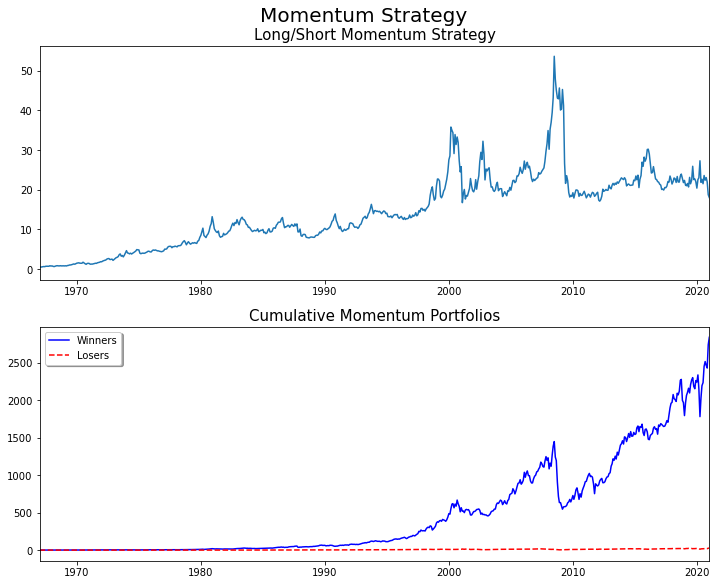

In [35]:
plt.figure(figsize=(12,9))
plt.suptitle('Momentum Strategy', fontsize=20)
ax1 = plt.subplot(211)
ax1.set_title('Long/Short Momentum Strategy', fontsize=15)
ax1.set_xlim([dt.datetime(1967,1,1), dt.datetime(2020,12,31)])
ax1.plot(ewret_t['cumret_long_short'])
ax2 = plt.subplot(212)
ax2.set_title('Cumulative Momentum Portfolios', fontsize=15)
ax2.plot(ewret_t['cumret_winners'], 'b-', ewret_t['cumret_losers'], 'r--')
ax2.set_xlim([dt.datetime(1967,1,1), dt.datetime(2020,12,31)])
ax2.legend(('Winners','Losers'), loc='upper left', shadow=True)
plt.subplots_adjust(top=0.92, hspace=0.2)

### Testing with FF MOM

In [36]:
# Obtaining Fama-French MOM factors
ff_mom = pd.read_csv('FF_mom.csv', skiprows = 12, nrows=1128, index_col = 0)

# Setting monthly index
ff_mom.index = pd.to_datetime(ff_mom.index, format= '%Y%m')
ff_mom.index = ff_mom.index.to_period('M')

# Renaming column
ff_mom.rename(columns={ ff_mom.columns[0]: "mom" }, inplace = True)

In [37]:
# Set monthly index for MOM strategy
mom = ewret_t
mom.index = mom.index.to_period('M')

In [38]:
# Creating dataframe
test_df = pd.merge(mom['long_short'], ff_mom, left_index=True, right_index=True)

In [39]:
# Correlation 
test_df['long_short'].corr(test_df['mom'])

0.8973824240872752

## LSTM PREP

In [59]:
#LSTM_data = holding_df
#LSTM_data.groupby('permno').count()

In [60]:
#formation_mc = formation_mc.rename(columns={"date": "form_date"})
#formation_mc.groupby('permno').count()

In [61]:
# Including cumreturn and merging ong formation date
#LSTM_data_m = pd.merge(LSTM_data, formation_mc[['permno','form_date','mkt_cap','cumret']], on=['permno', 'form_date'], how='left')
#LSTM_data_m

In [62]:
#LSTM_data_m = LSTM_data_m.set_index(LSTM_data_m['hdate2'], drop=False, inplace=False)
#LSTM_data_m

In [63]:
#LSTM_data_m = LSTM_data_m[['permno', 'momr', 'ret', 'mkt_cap', 'cumret']]
#LSTM_data_m

In [64]:
# Saving file as CSV for the LSTM model
#LSTM_data_m.to_csv('LSTM_data_m.csv', index=True)